#Imports

In [ ]:
pip install svgling

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 1.6 MB/s eta 0:00:00


In [ ]:
import yfinance as yf
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from svgling import draw_tree
import nltk
from IPython.display import display
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
from datetime import datetime

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

#Creating DF from historic data


In [ ]:
stock = str(input("Enter a stock: "))
ticker = yf.Ticker(stock)
df = ticker.history(period="5y")

Enter a stock: HDFCBANK.NS


In [ ]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-07-18 00:00:00+05:30,1150.852985,1163.304994,1150.326122,1155.115356,5401292,0.0,0.0
2019-07-19 00:00:00+05:30,1156.600078,1159.329918,1133.611754,1137.754395,4469614,0.0,0.0
2019-07-22 00:00:00+05:30,1123.075504,1125.398330,1092.544134,1100.206909,11085648,0.0,0.0
2019-07-23 00:00:00+05:30,1098.889716,1098.889716,1073.770208,1084.043091,13901432,0.0,0.0
2019-07-24 00:00:00+05:30,1080.810269,1098.171240,1078.056459,1092.376221,8681870,0.0,0.0


In [ ]:
del df["Dividends"]
del df["Stock Splits"]
df["tomorrow"] = df["Close"].shift(-1)
df["yesterday"] = df["Close"].shift(1)
df.dropna(inplace=True)
df.head()

,Open,High,Low,Close,Volume,tomorrow,yesterday
Date,,,,,,,
2019-07-19 00:00:00+05:30,1156.600078,1159.329918,1133.611754,1137.754395,4469614,1100.206909,1155.115356
2019-07-22 00:00:00+05:30,1123.075504,1125.398330,1092.544134,1100.206909,11085648,1084.043091,1137.754395
2019-07-23 00:00:00+05:30,1098.889716,1098.889716,1073.770208,1084.043091,13901432,1092.376221,1100.206909
2019-07-24 00:00:00+05:30,1080.810269,1098.171240,1078.056459,1092.376221,8681870,1094.842896,1084.043091
2019-07-25 00:00:00+05:30,1094.340003,1108.923197,1092.065116,1094.842896,9731004,1090.652466,1092.376221


In [ ]:
df = df.reset_index()
df['Date'] = df['Date'].astype(str)
df['Date'] = df['Date'].apply(lambda x: x.split(" ")[0])
df.head()

,Date,Open,High,Low,Close,Volume,tomorrow,yesterday
0,2019-07-19,1156.600078,1159.329918,1133.611754,1137.754395,4469614,1100.206909,1155.115356
1,2019-07-22,1123.075504,1125.398330,1092.544134,1100.206909,11085648,1084.043091,1137.754395
2,2019-07-23,1098.889716,1098.889716,1073.770208,1084.043091,13901432,1092.376221,1100.206909
3,2019-07-24,1080.810269,1098.171240,1078.056459,1092.376221,8681870,1094.842896,1084.043091
4,2019-07-25,1094.340003,1108.923197,1092.065116,1094.842896,9731004,1090.652466,1092.376221


#Construct a function to create DF

In [ ]:
def create_df(stock):
    ticker = yf.Ticker(stock)
    df = ticker.history(period="5y")
    del df["Dividends"]
    del df["Stock Splits"]
    df["tomorrow"] = df["Close"].shift(-1)
    df["yesterday"] = df["Close"].shift(1)
    df.dropna(inplace=True)
    df = df.reset_index()
    df['Date'] = df['Date'].astype(str)
    df['Date'] = df['Date'].apply(lambda x: x.split(" ")[0])
    return df

#Web Scrapping

In [ ]:
def convert_date(date_str):
    dt = datetime.strptime(date_str, '%b-%d-%y')
    return dt.strftime('%Y-%m-%d')

In [ ]:
def scrap_data(new_ticker):
  finviz_url = "https://finviz.com/quote.ashx?t="

  url = finviz_url + new_ticker

  req = Request(url = url, headers = {"user-agent": "my-app"})
  response = urlopen(req)

  html = BeautifulSoup(response, "html")

  news_table = html.find(id = "news-table")
  news_rows = news_table.findAll("tr")

  parsed_data = []

  for index, row in enumerate(news_rows):

    title_a = row.find('a', class_='tab-link-news')
    if title_a:
      title = title_a.text
    else:
      title = np.nan
    timestamp = row.td.text.strip().split(" ")

    if len(timestamp) == 1:
      date = temp
    else:
      date = timestamp[0]
      temp = timestamp[0]

    parsed_data.append([date, title])

  df = pd.DataFrame(parsed_data, columns = ["date","title"])
  df.dropna(inplace=True)
  df = df.reset_index()

  del df["index"]

  df['date'] = df['date'].apply(convert_date)
  df['index'] = df.index

  return df

In [ ]:
df = scrap_data("HDB")
df.head()

,date,title,index
0,2024-07-12,Should Investors Buy HDFC Bank (NYSE:HBD) for ...,0
1,2024-07-12,Top 25 global banks add 5.4% market value duri...,1
2,2024-07-09,Does HDFC Bank (HDB) Have a Low Incremental Ma...,2
3,2024-07-03,MUFGs Talks for Stake in India Consumer Lender...,3
4,2024-06-18,Do You Think HDFC Bank Limited (HDB) Has a Lon...,4


#Sentiment Analysis

In [ ]:
example = df['title'][5]
example

'Earnings Miss and Cautious Full-Year 2024 Outlook Dragged Lindblad Expeditions Holdings (LIND) in Q1'

In [ ]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
tokens = nltk.word_tokenize(example)
tags = nltk.pos_tag(tokens)
chunks = nltk.chunk.ne_chunk(tags)

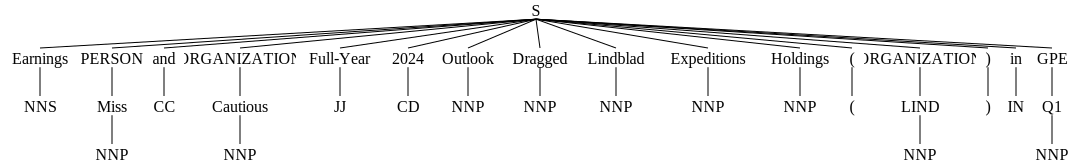

In [ ]:
display(draw_tree(chunks))

In [ ]:
analyzer = SentimentIntensityAnalyzer()
analyzer.polarity_scores(example)

{'neg': 0.276, 'neu': 0.724, 'pos': 0.0, 'compound': -0.296}

#Function fot sentiment analysis

In [ ]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
def compound_scores(df):
  analyzer = SentimentIntensityAnalyzer()
  result = []

  for i, row in tqdm(df.iterrows(), total = len(df)):
    text = row['title']
    index = row['index']
    tokens = nltk.word_tokenize(text)
    tags = nltk.pos_tag(tokens)
    chunks = nltk.chunk.ne_chunk(tags)
    sentiment = analyzer.polarity_scores(text)
    compound = sentiment['compound']
    result.append(compound)

  df['compound'] = result
  del df["title"]

  df = df.groupby('date', as_index=False)['compound'].mean()

  return df

In [ ]:
df = compound_scores(df)

  0%|          | 0/100 [00:00<?, ?it/s]

#Merging the dataframes


In [ ]:
df1 = create_df('HDFCBANK.NS')
df2 = scrap_data('HDB')

In [ ]:
df2 = compound_scores(df2)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
data = pd.merge(df1, df2, how='left', left_on='Date', right_on='date').fillna({'compound': 0})
data.drop(columns=['date'], inplace=True)

In [ ]:
del data['Date']
data

,Open,High,Low,Close,Volume,tomorrow,yesterday,compound
0,1098.889840,1098.889840,1073.770328,1084.043213,13901432,1092.376343,1100.206787,0.00000
1,1080.810389,1098.171363,1078.056580,1092.376343,8681870,1094.842896,1084.043213,0.00000
2,1094.340003,1108.923197,1092.065116,1094.842896,9731004,1090.652466,1092.376343,0.00000
3,1091.083450,1098.482795,1088.521280,1090.652466,6414914,1074.847900,1094.842896,0.00000
4,1088.856411,1088.856411,1064.670777,1074.847900,4988246,1078.655396,1090.652466,0.00000
...,...,...,...,...,...,...,...,...
1228,1622.000000,1638.400024,1611.150024,1622.699951,28024980,1622.099976,1621.900024,0.43785
1229,1623.500000,1629.800049,1615.199951,1622.099976,16687847,1619.750000,1622.699951,0.00000
1230,1620.750000,1627.000000,1616.800049,1619.750000,14475162,1614.800049,1622.099976,0.00000
1231,1608.000000,1623.949951,1599.150024,1614.800049,16858532,1607.300049,1619.750000,0.00000


#XGB

In [ ]:
y = data['Close']
X = data.drop(columns=['Close'])

In [ ]:
y_test = y[-50:]
y_train = y[:-50]
X_test = X[-50:]
X_train = X[:-50]

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [ ]:
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}

In [ ]:
epochs = 100
model = xgb.train(params, dtrain, epochs)

In [ ]:
y_pred = model.predict(dtest)

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse}")

Root Mean Squared Error: 17.842257569669293


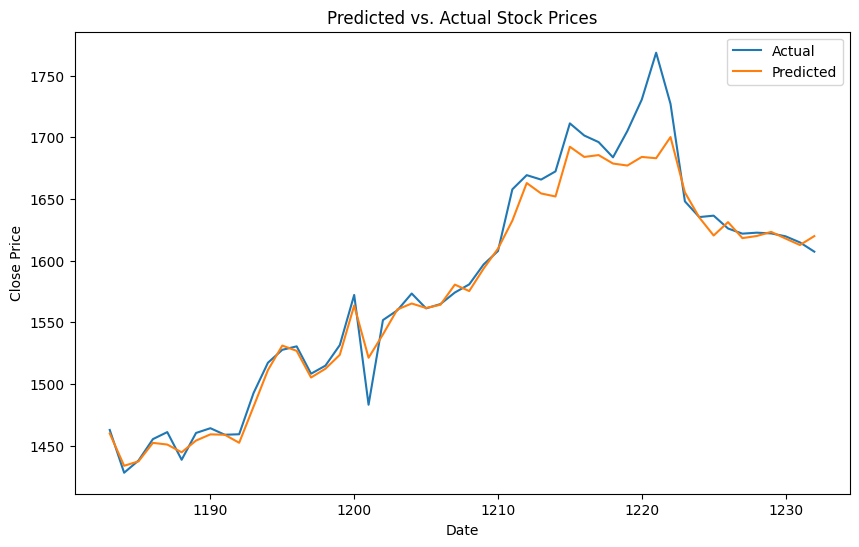

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(data.index[-50:], y_test, label='Actual')
plt.plot(data.index[-50:], y_pred, label='Predicted')
plt.title('Predicted vs. Actual Stock Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()